In [1]:
from navec import Navec
import json
import pandas as pd
from pymystem3 import Mystem
import re
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorboard.plugins import projector
from gensim.models import Doc2Vec
import gensim

In [2]:
%load_ext tensorboard

In [3]:
# загружем размеченные resps
df = pd.read_excel('resps.xlsx').drop_duplicates()
df.head()

,note,resp
0,"Внедрение, развитие и поддержка практики DQ",•Формирование подходов по реализации процесса ...
1,Остальное,3я линия поддержки платформы взаимодействия УК...
2,Остальное,Автоматизация процессов обработки расхождений
3,DQ-инструмент,Автоматизация тестирования данных;
4,Остальное,Автоматизировать процессы по работе с данными;


In [4]:
sorted(list(df.note.unique()))

['DQ-инструмент',
 'DQ-мониторинг',
 'Анализ данных',
 'Внедрение изменений',
 'Внедрение, развитие и поддержка практики DQ',
 'Коммуникации',
 'Корневые причины',
 'Методология',
 'Остальное',
 'Отчеты по DQ',
 'Требования к данным и процессам',
 'Управление DQ-инцидентами',
 'Управление DQ-проверками']

In [5]:
# назначаем цвета
colors = {
    'DQ-инструмент': '#2D2D2A', # темно-серый
    'DQ-мониторинг': '#3F6C51', # темно-зеленый
    'Анализ данных': '#E13700', # ярко-оранжевый
    'Внедрение изменений': '#FFFC31', # ярко-желтый
    'Внедрение, развитие и поддержка практики DQ': '#C287E8', # фиолетовый
    'Коммуникации': '#000000', # черный 
    'Корневые причины': '#EE2677', # розовый
    'Методология': '#006E90', # синий
    'Остальное': '#ADCAD6', # серый светлый
    'Отчеты по DQ': '#A8763E', # коричневый
    'Требования к данным и процессам': '#E49273', # кремовый
    'Управление DQ-инцидентами': '#C14953', # бледно красный
    'Управление DQ-проверками': '#9EE493' # светло зеленый
}

In [ ]:
# усредненные эмбеддинги с лемматизацией
m = Mystem()
resps2 = [m.lemmatize(x) for x in df.resp]

In [7]:
resps3 = [[re.sub('[^а-яА-Я ]+', '', y).lower().strip() for y in x] for x in resps2]

In [8]:
resps4 = []
for x in resps3:
    x2 = []
    for y in x:
        if y not in stopwords.words("russian") and y.strip() not in [' ', '', '\n']:
            x2.append(y)
    resps4.append(x2)

In [9]:
# получаем вектор для документа путем усреднения векторов для каждого слова
# https://github.com/natasha/navec
navec = Navec.load('D:/tmp/navec_hudlit_v1_12B_500K_300d_100q.tar')
def calc_avg_vector(l):
    total = 0
    n = 0
    for item in l:
        if item in navec:
            total += navec[item]
            n += 1
    if n != 0:
        return total / n
    else:
        return navec['<unk>']
v1 = [calc_avg_vector(x) for x in resps4]

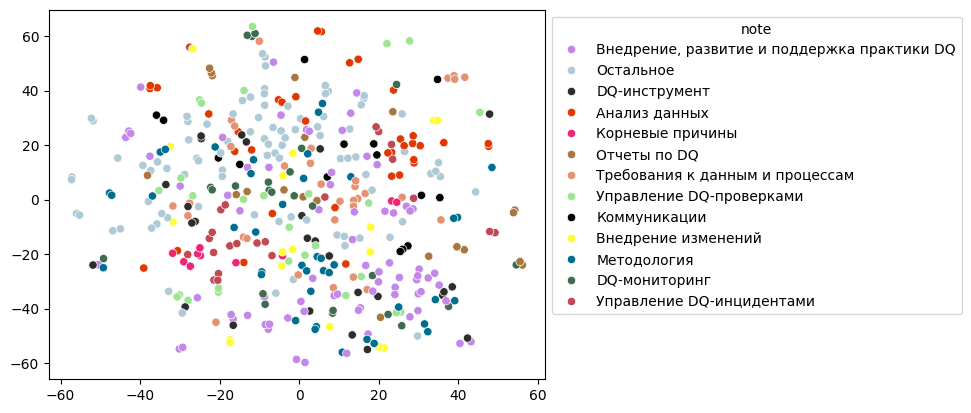

In [10]:
# рисуем t-SNE
tsne = TSNE(n_components=2, n_iter=1000, perplexity=10)
X = np.array(v1)
X_tsne = tsne.fit_transform(X)
ax = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue = df.note, palette=colors)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [11]:
# попробуем убрать неконкретные категории и построить вектора с помощью doc2vec
df2 = df.query("~note.isin(['Внедрение, развитие и поддержка практики DQ', 'Методология', 'Остальное', 'Коммуникации'])")
documents = []
for i, item in enumerate(resps4):
    if i in df2.index:
        documents.append(gensim.models.doc2vec.TaggedDocument(item, [str(i)]))
model = Doc2Vec(documents, dm=1, window=8, min_count=5, workers=4)

In [12]:
# полученные вектора визуализируем с помощью tensorboard
v2 = model.dv.vectors
checkpoint = tf.train.Checkpoint(embedding=tf.Variable(v2))
checkpoint.save('embedding.ckpt')
df2.to_csv('metadata.tsv', index=False, sep='\t', header=True)
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "tensor"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings('', config)

In [13]:
# http://localhost:6006/?darkMode=true#projector
%tensorboard --logdir './'

In [ ]:
# файлы vectors.tsv и metadata.tsv также можно
# загрузить на https://projector.tensorflow.org/ 
pd.DataFrame(v2).to_csv('vectors.tsv', index=False, sep='\t', header=False)